# Data Processing and Feature Engineering

## 1.Data Cleaning

### Loading data set using Pandas

In [63]:
import pandas as pd
import matplotlib.pyplot as plt

train=pd.read_csv('train.csv')
test=pd.read_csv('test.csv')
stores=pd.read_csv('stores.csv')
oil=pd.read_csv('oil.csv')
holidays_events=pd.read_csv('holidays_events.csv')

print(train.head())
print(test.head())

   id        date  store_nbr      family  sales  onpromotion
0   0  2013-01-01          1  AUTOMOTIVE    0.0            0
1   1  2013-01-01          1   BABY CARE    0.0            0
2   2  2013-01-01          1      BEAUTY    0.0            0
3   3  2013-01-01          1   BEVERAGES    0.0            0
4   4  2013-01-01          1       BOOKS    0.0            0
        id        date  store_nbr      family  onpromotion
0  3000888  2017-08-16          1  AUTOMOTIVE            0
1  3000889  2017-08-16          1   BABY CARE            0
2  3000890  2017-08-16          1      BEAUTY            2
3  3000891  2017-08-16          1   BEVERAGES           20
4  3000892  2017-08-16          1       BOOKS            0


In [64]:
train.isna().sum()   # No Missing Value

id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64

In [65]:
test.isnull().sum()  # No Missing Value

id             0
date           0
store_nbr      0
family         0
onpromotion    0
dtype: int64

In [66]:
stores.isna().sum()  # No Missing Value

store_nbr    0
city         0
state        0
type         0
cluster      0
dtype: int64

In [67]:
holidays_events.isna().sum() # No Missing Value

date           0
type           0
locale         0
locale_name    0
description    0
transferred    0
dtype: int64

In [69]:
oil.isna().sum()

date           0
dcoilwtico    43
dtype: int64

In [75]:
# Handling Missing Values using Interpolation
oil['dcoilwtico']=oil['dcoilwtico'].interpolate()

In [77]:
# Converting date columns to proper datetime formats

train['date']=pd.to_datetime(train['date'])
test['date'] = pd.to_datetime(test['date'])
oil['date'] = pd.to_datetime(oil['date'])
holidays_events['date'] = pd.to_datetime(holidays_events['date'])

In [78]:
# Merging data from stores,oil,holidays_events into the main dataset

df_train=train.merge(stores,on='store_nbr',how='left')
df_train=df_train.merge(oil,on='date',how='left')
df_train=df_train.merge(holidays_events,on='date',how='left')

df_test = test.merge(stores, on='store_nbr', how='left')
df_test = df_test.merge(oil, on='date', how='left')
df_test = df_test.merge(holidays_events, on='date', how='left')

In [79]:
df_train.head()

,id,date,store_nbr,family,sales,onpromotion,city,state,type_x,cluster,dcoilwtico,type_y,locale,locale_name,description,transferred
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,NaN,Holiday,National,Ecuador,Primer dia del ano,False
1,1,2013-01-01,1,BABY CARE,0.0,0,Quito,Pichincha,D,13,NaN,Holiday,National,Ecuador,Primer dia del ano,False
2,2,2013-01-01,1,BEAUTY,0.0,0,Quito,Pichincha,D,13,NaN,Holiday,National,Ecuador,Primer dia del ano,False
3,3,2013-01-01,1,BEVERAGES,0.0,0,Quito,Pichincha,D,13,NaN,Holiday,National,Ecuador,Primer dia del ano,False
4,4,2013-01-01,1,BOOKS,0.0,0,Quito,Pichincha,D,13,NaN,Holiday,National,Ecuador,Primer dia del ano,False


In [122]:
df_train.onpromotion.unique().sum()

82566

## 2.Feature Engineering

In [82]:
# Extracting Time based Features

df_train['day']=df_train['date'].dt.day
df_train['month']=df_train['date'].dt.month
df_train['year']=df_train['date'].dt.year
df_train['day_of_week']=df_train['date'].dt.dayofweek

df_test['day'] = df_test['date'].dt.day
df_test['month'] = df_test['date'].dt.month
df_test['year'] = df_test['date'].dt.year
df_test['day_of_week'] = df_test['date'].dt.dayofweek

In [83]:
# Creating binary flags for holidays

df_train['is_holiday']=df_train['type_y'].notna().astype(int)
df_train['is_weekend']=(df_train['day_of_week'] >=5).astype(int)

df_test['is_holiday']=df_test['type_y'].notna().astype(int)
df_test['is_weekend']=(df_test['day_of_week'] >=5).astype(int)

In [84]:
#df_train.head()

In [85]:
# Identify if sales are higher in December (holiday season)
df_train['is_december'] = (df_train['month'] == 12).astype(int)
df_train['is_november'] = (df_train['month'] == 11).astype(int)  # Black Friday Effects
df_train['is_january'] = (df_train['month'] == 1).astype(int)  # Post-holiday drop

# Quarterly seasonality (Q1, Q2, Q3, Q4)
df_train['quarter'] = df_train['date'].dt.quarter

# Store-specific seasonal sales trend (Avg sales per month)
df_train['monthly_avg_sales'] = df_train.groupby(['store_nbr', 'family', 'month'])['sales'].transform('mean')

# Rolling Window for Seasonal Trends
df_train['rolling_mean_30'] = df_train.groupby(['store_nbr', 'family'])['sales'].transform(lambda x: x.rolling(30, min_periods=1).mean())

# Display a preview
print(df_train[['date', 'sales', 'month', 'is_december', 'is_november', 'is_january', 'quarter', 'monthly_avg_sales']].head())

# Identify if sales are higher in December (holiday season)
df_test['is_december'] = (df_test['month'] == 12).astype(int)
df_test['is_november'] = (df_test['month'] == 11).astype(int)  # Black Friday Effects
df_test['is_january'] = (df_test['month'] == 1).astype(int)  # Post-holiday drop

# Quarterly seasonality (Q1, Q2, Q3, Q4)
df_test['quarter'] = df_test['date'].dt.quarter

# Display a preview
#print(df_test[['date', 'month', 'is_december', 'is_november', 'is_january', 'quarter']].head())

        date  sales  month  is_december  is_november  is_january  quarter  \
0 2013-01-01    0.0      1            0            0           1        1   
1 2013-01-01    0.0      1            0            0           1        1   
2 2013-01-01    0.0      1            0            0           1        1   
3 2013-01-01    0.0      1            0            0           1        1   
4 2013-01-01    0.0      1            0            0           1        1   

   monthly_avg_sales  
0           3.141935  
1           0.000000  
2           2.129032  
3        1615.354839  
4           0.167742  


In [89]:
#How This Captures Seasonal Trends?
#Monthly Sales Trends: Adds is_december, is_november, and is_january to identify holiday effects.
#
#Quarterly Seasonality: Adds quarter to capture trends across business quarters.
#
#Monthly Averages: Computes average sales per month for each store-product combination.
#
#Rolling Window (30 days): Helps smooth short-term fluctuations in sales.

In [95]:
# Creating binary flags for payday

df_train['is_payday']=df_train['day'].isin([15] + df_train['date'].dt.days_in_month.tolist()).astype(int)

df_test['is_payday']=df_test['day'].isin([15] + df_test['date'].dt.days_in_month.tolist()).astype(int)

In [97]:
# Adding Earthquake Impact feature

df_train['is_earthquake']=(df_train['date'] == '2016-04-16').astype(int)

df_test['is_earthquake']=(df_test['date'] == '2016-04-16').astype(int)

In [99]:
# Rolling Statistics

df_train['lag_7']=df_train.groupby(['store_nbr','family'])['sales'].shift(7)
df_train['lag_30']=df_train.groupby(['store_nbr','family'])['sales'].shift(30)

df_train['rolling_mean_7']=df_train.groupby(['store_nbr','family'])['sales'].transform(lambda x:x.rolling(7).mean())
df_train['rolling_std_7']=df_train.groupby(['store_nbr','family'])['sales'].transform(lambda x:x.rolling(7).std())

In [146]:
# Compute average sales per store type
store_type_sales = df_train.groupby('type_x')['sales'].mean().reset_index()
print("Average Sales per Store Type:")
store_type_sales['sales'] = store_type_sales['sales'].apply(lambda x: '{:,.2f}'.format(x))
print(store_type_sales)

Average Sales per Store Type:
  type_x   sales
0      A  708.38
1      B  328.28
2      C  197.79
3      D  352.08
4      E  270.29


In [148]:
# Identify top-selling product families per cluster
top_products_per_cluster = df_train.groupby(['cluster', 'family'])['sales'].sum().reset_index()
top_products_per_cluster = top_products_per_cluster.sort_values(['cluster', 'sales'], ascending=[True, False])
top_products_per_cluster = top_products_per_cluster.groupby('cluster').head(3)
print("Top Selling Product Families per Cluster:")
top_products_per_cluster['sales'] = top_products_per_cluster['sales'].apply(lambda x: '{:,.2f}'.format(x))
print(top_products_per_cluster)

Top Selling Product Families per Cluster:
     cluster     family          sales
12         1  GROCERY I  14,832,839.00
3          1  BEVERAGES  12,012,521.00
30         1    PRODUCE   8,221,405.85
45         2  GROCERY I   8,649,030.17
36         2  BEVERAGES   5,503,139.00
63         2    PRODUCE   5,068,958.65
78         3  GROCERY I  29,786,103.67
69         3  BEVERAGES  14,959,384.00
73         3   CLEANING  10,103,208.00
111        4  GROCERY I  16,825,191.92
102        4  BEVERAGES   8,343,193.00
129        4    PRODUCE   6,143,159.74
144        5  GROCERY I  16,715,953.82
135        5  BEVERAGES  13,696,172.00
162        5    PRODUCE  10,896,401.52
177        6  GROCERY I  43,971,769.79
168        6  BEVERAGES  23,628,801.00
172        6   CLEANING  12,271,643.00
210        7  GROCERY I   6,163,853.26
201        7  BEVERAGES   2,536,783.00
205        7   CLEANING   2,295,478.00
243        8  GROCERY I  27,684,913.96
234        8  BEVERAGES  23,763,744.00
261        8    PRODUC

### Exploratory Data Analysis

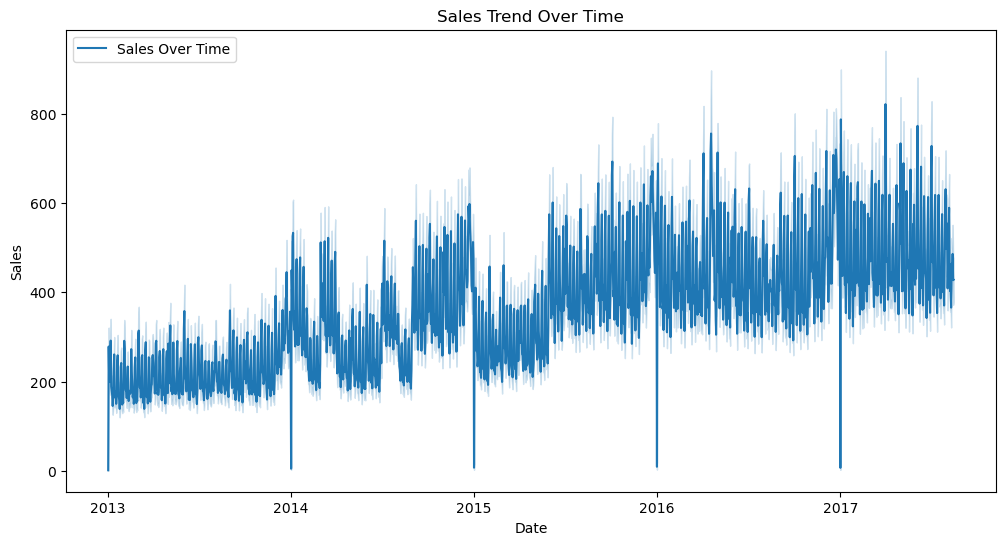

In [104]:
# Sales Trends over Time
import seaborn as sns
plt.figure(figsize=(12,6))
sns.lineplot(data=df_train, x='date', y='sales', label='Sales Over Time')
plt.title('Sales Trend Over Time')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

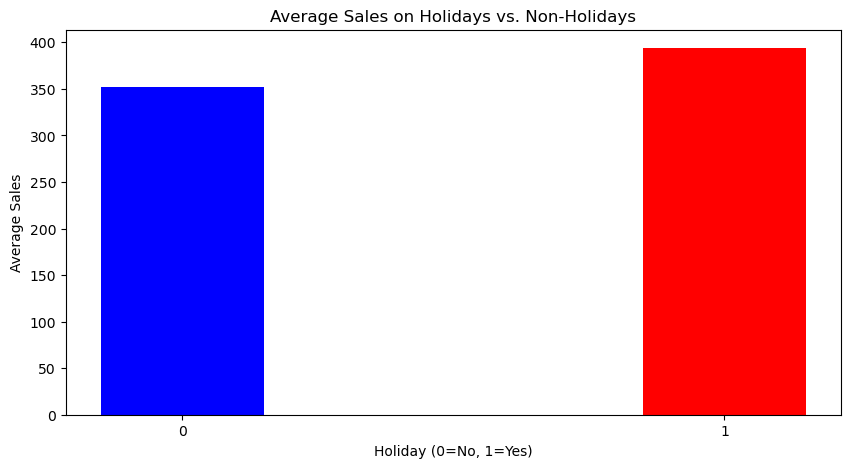

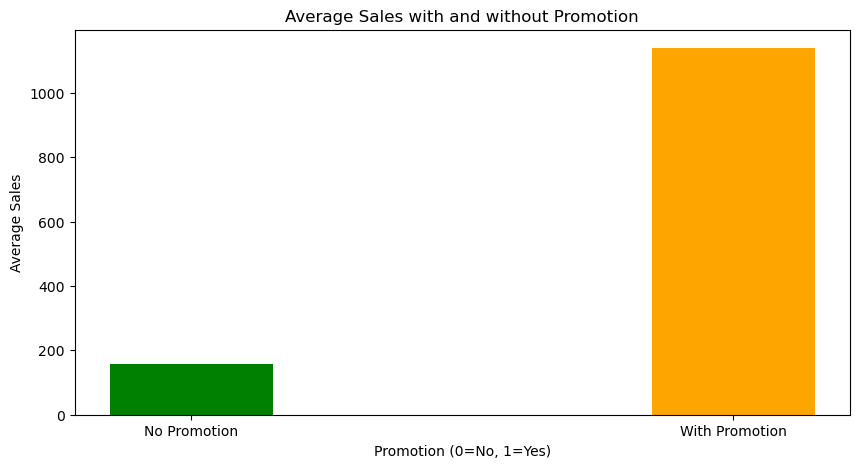

In [134]:
# Analyze Sales Before and After Holidays and Promotions
holiday_sales = df_train.groupby('is_holiday')['sales'].mean().reset_index()
df_train['promotion_flag'] = df_train['onpromotion'].apply(lambda x: 'No Promotion' if x == 0 else 'With Promotion')
promo_sales = df_train.groupby('promotion_flag')['sales'].mean().reset_index()

plt.figure(figsize=(10, 5))
plt.bar(holiday_sales['is_holiday'].astype(str), holiday_sales['sales'], color=['blue', 'red'], width=0.3)
plt.title('Average Sales on Holidays vs. Non-Holidays')
plt.xlabel('Holiday (0=No, 1=Yes)')
plt.ylabel('Average Sales')
plt.show()

plt.figure(figsize=(10, 5))
plt.bar(promo_sales['promotion_flag'], promo_sales['sales'], color=['green', 'orange'], width=0.3)
plt.title('Average Sales with and without Promotion')
plt.xlabel('Promotion (0=No, 1=Yes)')
plt.ylabel('Average Sales')
plt.show()

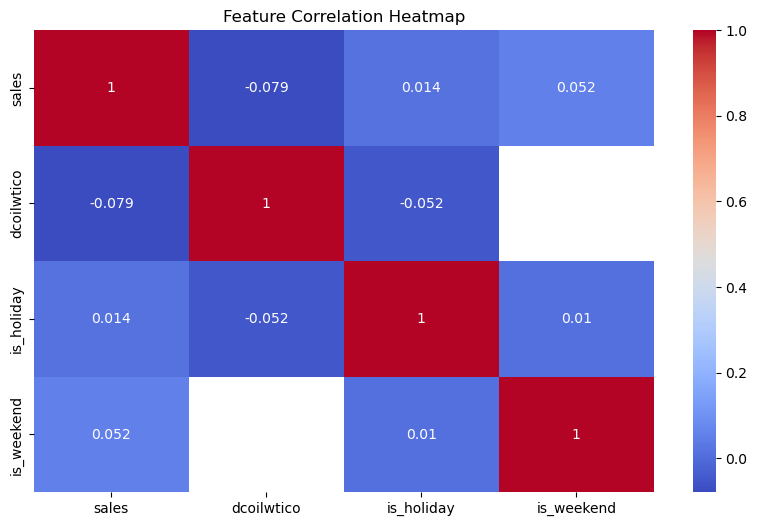

In [108]:
# Correlation Heatmap
plt.figure(figsize=(10,6))
sns.heatmap(df_train[['sales', 'dcoilwtico', 'is_holiday', 'is_weekend']].corr(), annot=True, cmap='coolwarm')
plt.title('Feature Correlation Heatmap')
plt.show()

# Model Selection,Forecasting and Evaluation

In [22]:
from sklearn.model_selection import train_test_split

features=['day','month','year','day_of_week','is_holiday','is_weekend',
          'is_payday','is_earthquake','lag_7','lag_30','mean_7','std_7']
x=df_train[features]
y=df_train['sales']

x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=42)


In [23]:
# Baseline Model(Naive Forecasting)
y_pred_baseline=df_train.groupby(['store_nbr','family'])['sales'].shift(1)

# Assuming future sales = Previous sales

In [24]:
# ARIMA Model
import warnings
warnings.filterwarnings('ignore')
from statsmodels.tsa.arima.model import ARIMA

arima_model=ARIMA(y_train,order=(5,1,0))
arima_model_fit=arima_model.fit()
y_pred_arima=arima_model_fit.forecast(steps=len(y_test))

C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [25]:
# RandomForest Model

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

rf_model=RandomForestRegressor(n_estimators=100,random_state=42)
rf_model.fit(x_train,y_train)
y_pred_rf=rf_model.predict(x_test)

rmse_rf=mean_squared_error(y_test,y_pred_rf,squared=False)
print(f'RandomForest RMSE: {rmse_rf}')

MemoryError: could not allocate 67108864 bytes

In [ ]:
# XGBoost Model

from xgboost import XGBRegressor

xgb_model=XGBRegressor(n_estimators=100,learning_rate=0.1,max_depth=5)
xgb_model.fit(x_train,y_train)
y_pred_xgb=xgb_model.predict(x_test)

rmse_xgb=mean_squared_error(y_test,y_pred_xgb,squared=False)
print(f'XGBoost RMSE: {rmse_xgb}')

In [ ]:
# LSTM Model

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

x_train_lstm=x_train.values.reshape((x_train.shape[0],x_train.shape[1],1))
x_test_lstm=x_test.values.reshape((x_test.shape[0],x_test.shape[1],1))

lstm_model= Sequential([
    LSTM(50,activation='relu',input_shape=(x_train_lstm.shape[1],1)),Dense(1)
])
lstm_model.compile(optimizer='adam',loss='mse')
lstm_model.fit(x_train_lstm,y_train,epochs=10,batch_size=64,validation_data=(x_test_lstm,y_test))
y_pred_lstm=lstm_model.predict(x_test_lstm)

rmse_lstm = means_squared_error(y_test,y_pred_lstm,squared=False)
print(f'LSTM RMSE: {rmse_lstm}')

### Model Evaluation

In [ ]:
from sklearn.metrics import mean_absolute_percentage_error

def eval(y_actual,y_pred,model):
    rmse=mean_squared_error(y_actual,y_pred,squared=False)
    mape=mean_absolute_percentage_error(y_actual,y_pred)
    #mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100  # Avoid division by zero issues
    r2 = r2_score(y_actual,y_pred)
    
    print(f'{model} - RMSE: {rmse}, MAPE: {mape},R2: {r2}')
    #print(f"{model_name} - RMSE: {rmse:.2f}, MAPE: {mape:.2f}%, R²: {r2:.4f}")

eval(y_test,y_pred_arima,'ARIMA')
eval(y_test,y_pred_rf,'RandomForest')
eval(y_test,y_pred_xgb,'XGBoost')
eval(y_test,y_pred_lstm,'LSTM')

### Visualization

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12,6))
plt.plot(y_test.values,label='Actual')
plt.plot(y_pred_arima,label='ARIMA')
plt.plot(y_pred_baseline,label='BaseLine')
plt.plot(y_pred_rf,label='RandomForest')
plt.plot(y_pred_xgb,label='XGBoost')
plt.plot(y_pred_lstm,label='LSTM')
plt.legend()
plt.title('Sales Forecasting Comparison')
plt.show()

In [ ]:
Impact of External Factors:

Holidays and oil prices significantly impact sales.

Government payday increases sales.

Business Strategy Recommendations:

Adjust promotions based on oil prices.

Stock more inventory before payday and holidays.